# Content
[**Data Processing**](#data-proc) 
* [**Data Cleaning**](#cleaning) 
 
[**Analysis**](#analysis) 
- [**Growth of EV Stations**](#ev-st-growth) 
- [**Charger Types (Levels)**](#charge-levels) 
- [**EV Connector Types**](#conn-types)
- [**EV Pricing**](#ev-pricing) 
- [**Map of EV Locations (Interactive)**](#ev-map-interactive) 
    - [**Some Map Excerpts**](#map-excerpts)
    
[**Closing Remarks**](#closing) \
[**Sources**](#sources)


In [107]:
# imports
import requests
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json

import sys

own_package_paths = ['..\\src']
sys.path += own_package_paths

# import module
from data import processing

# ensure autoreload of edited imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data Processing <a class="anchor" id="data-proc"></a>

In [115]:
path = os.path.normpath(r'../data/raw/raw_data.csv')
raw_data = processing.get_raw_data(path, update=False)
n_rows, n_cols = raw_data.shape
print(raw_data.shape)

(1779, 69)


The raw dataset is a subset of the alternative fuelling station dataset made available [here](https://natural-resources.canada.ca/energy-efficiency/transportation-alternative-fuels/electric-charging-alternative-fuelling-stationslocator-map/20487#/analyze?region=CA-BC&fuel=ELEC&status=E&status=P&country=CA) by Natural Resources Canada (NRCan). 

NRCan *obtains information about new stations from trade media, the Submit New Station form on the Station Locator website, and through collaborating with infrastructure equipment and fuel providers, original equipment manufacturers (OEMs), and industry groups.*

~~The dataset is collected using different means including form submission available on the website, and information tion relevant industry and OEMs.

To ensure data integrity, station data points are checked annually and updated as necessary. Subsequently, the data on the stations exist as is.
The subset in this work consist of records on electric vehicle (EV) charging stations across British Columbia, Canada. 

For the purposes of the analysis, the stations are further limited to the following properties:

- public access
- stations that are available or planned to be
- level 2 and DC fast charger types


## Data Cleaning <a class="anchor" id="cleaning"></a>

Some columns are expected to be constant (single unique value) in the dataset given that there are columns used as filters.
Such columns are automatically removed to trim the raw data for downstream processing

In [117]:
# British Columbia Boundaries. Source: https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-1-states-provinces/
BC_MAX_LAT = 60.00
BC_MAX_LON = -114.03
BC_MIN_LAT = 48.30
BC_MIN_LON = -139.06

BC_boundaries = {'lat_min':BC_MIN_LAT,
                'lat_max': BC_MAX_LAT,
                'lon_min': BC_MIN_LON,
                'lon_max':BC_MAX_LON}

def bound_to_bc(df, BC_boundaries):
    '''
    This filters the input dataset and returns only the subset 
    where the latitude and longitude values are within the boundaries set.
    
    Note: This was needed to catch some outlier location (somewhere in Quebec) 
    points seen when visualizing the map later in the analysis
    '''
    bc_only_df = df[(df['latitude'] >= BC_boundaries['lat_min']) &
                   (df['latitude'] <= BC_boundaries['lat_max']) &
                    (df['longitude'] >= BC_boundaries['lon_min']) &
                    (df['longitude'] <= BC_boundaries['lon_max'])
                   ].copy()
    
    return bc_only_df

# intitial data cleaning
df = (raw_data.loc[:, raw_data.nunique() != 1]
      .dropna(axis=1, how='all') # drop constant column
      .pipe(bound_to_bc, BC_boundaries) # trim datapoints outside BC
     )
print(df.shape)
n_stations_total, _ = df.shape
df.head(3)

(1776, 36)


access_days_time access_detail_code cards_accepted date_last_confirmed  \
0   24 hours daily                NaN            NaN          2020-03-05   
1   24 hours daily                NaN            NaN          2022-08-09   
2   24 hours daily                NaN            NaN          2022-08-09   

  expected_date groups_with_access_code     id   open_date owner_type_code  \
0           NaN                  Public  83426  2017-02-15               P   
1           NaN                  Public  83491  2020-08-21               P   
2           NaN                  Public  83492  2017-05-17               P   

  status_code  ...     ev_network ev_network_web                ev_pricing  \
0           E  ...  Non-Networked            NaN                      Free   
1           E  ...  Non-Networked            NaN  Free; donations accepted   
2           E  ...  Non-Networked            NaN                      Free   

  ev_renewable_source            access_days_time_fr  \
0                 NaN  Accessible 24 heures par jour   
1                 NaN             24 heures par jour   
2                 NaN  Accessible 24 heures par jour   

  intersection_directions_fr  groups_with_access_code_fr  \
0                        NaN                      Public   
1                        NaN                      Public   
2                        NaN                      Public   

            ev_pricing_fr ev_network_ids.station ev_network_ids.posts  
0                 Gratuit                    NaN                  NaN  
1  Gratuit; dons acceptés                    NaN                  NaN  
2                 Gratuit                    NaN                  NaN  

[3 rows x 36 columns]

In [6]:
df.apply(pd.unique)

access_days_time              [24 hours daily, Dealership business hours, 8a...
access_detail_code            [nan, CALL, LIMITED_HOURS, KEY_ALWAYS, CREDIT_...
cards_accepted                [nan, A Cash D Debit M V, Cash Debit M V, A M ...
date_last_confirmed           [2020-03-05, 2022-08-09, 2022-07-08, 2022-04-1...
expected_date                 [nan, 2022-10-01, 2022-11-15, 2022-09-01, 2022...
groups_with_access_code       [Public, Public - Call ahead, Public - Limited...
id                            [83426, 83491, 83492, 83527, 83550, 83732, 837...
open_date                     [2017-02-15, 2020-08-21, 2017-05-17, 2014-06-1...
owner_type_code                                             [P, T, LG, SG, nan]
status_code                                                              [E, P]
restricted_access                                            [False, True, nan]
station_name                  [City of Nanaimo - Underground Parking Lot, Fu...
station_phone                 [250-754-4

# Analysis <a class="anchor" id="analysis"></a>

## Growth of EV station <a class="anchor" id="ev-st-growth"></a>

In [122]:
col = 'status_code'
print(df[col].value_counts())

E    1579
P     197
Name: status_code, dtype: int64


In [123]:
df[df['open_date'].isna() & df['expected_date'].isna()].shape

(1, 36)

There is just one station without neither an expected/open date. This is negligible for the purposes of this analysis

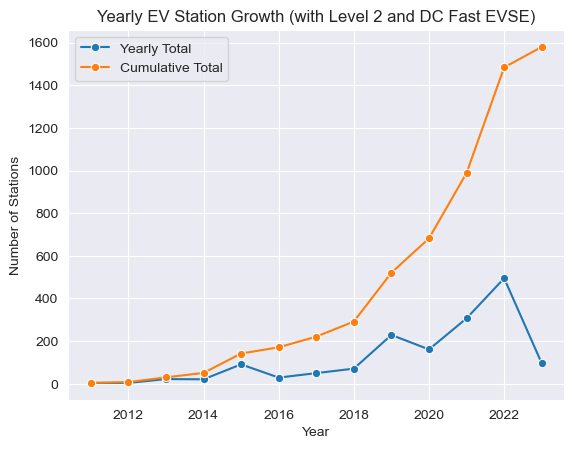

In [138]:
open_date = df['open_date'].copy()
# expected_date = df['expected_date'].copy()
# open_date[open_date.isna()] = expected_date


open_date_agg_df = (pd.DataFrame({'open_date':pd.to_datetime(open_date),'value': np.ones(len(open_date))})
                    .dropna()
                    .resample(rule='Y', on='open_date').agg({'value':np.sum})
                    .assign(cumsum = lambda x: np.cumsum(x['value']))
                    .assign(year=lambda x: x.index.year)
                    .reset_index())


# print(open_date_agg_df)
sns.set_style("darkgrid")
fig, ax = plt.subplots()
sns.lineplot(x='year', y='value', marker='o', data=open_date_agg_df, label='Yearly Total', ax=ax)
sns.lineplot(x='year', y='cumsum', marker='o', data=open_date_agg_df, label='Cumulative Total', ax=ax)
ax.set_ylabel('Number of Stations');
ax.set_xlabel('Year')
ax.set_title('Yearly EV Station Growth (with Level 2 and DC Fast EVSE)');

- A parabolic growhtt in the number of station is evident, which is somewhat expected given the push for EVs and the needed infrastructure
- It is still early days  in the 2023 and one might expect more stations to actually become available given the trend.
- caveat:
    - For electric vehicle charging stations added to the Station Locator through automated data feeds from charging networks, this is either the date provided by the charging network or the date it appeared in the Station Locator if the charging network does not provide an open date.

## Chrager Types (Levels) <a class="anchor" id="charge-levels"></a>

In the dataset, two EV charging level considered — level 2 and DC fast (DCFC or level 3). These levels are indicative of the charging power that may be delivered by the chargers. 
DCFC enables relatively faster charging than level 2 chrager which are inturn faster than level 1 (not considered here) chargers.

First the fraction of the stations with at least one of the charger types is considered.

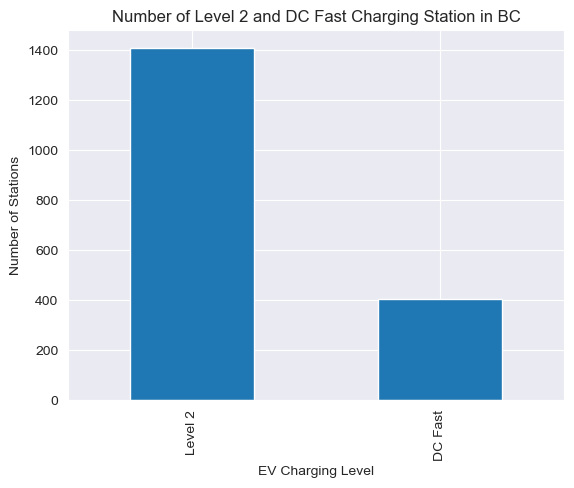

In [139]:
charger_type_names =  ('ev_level2_evse_num', 'ev_dc_fast_num')
charger_type_new_names = ('Level 2', 'DC Fast')

temp_df = (df[list(charger_type_names)].copy()
          .rename(columns={charger_type_names[0]:charger_type_new_names[0],
                            charger_type_names[1]:charger_type_new_names[1]})
           .apply(lambda x: sum(x > 0))
          ).plot.bar()

ax = plt.gca()
ax.set_ylabel('Number of Stations')
ax.set_xlabel('EV Charging Level')
ax.set_title('Number of Level 2 and DC Fast Charging Station in BC');


In [142]:

temp_df = (df[list(charger_type_names)].copy()
          .rename(columns={charger_type_names[0]:charger_type_new_names[0],
                            charger_type_names[1]:charger_type_new_names[1]})
           .apply(lambda x: sum(x > 0) / n_stations_total)
          )
           
print(temp_df)

Level 2    0.793919
DC Fast    0.226914
dtype: float64


The result shows that level 2 chargers are more available at about 79% of the stations compared to just about 23% of stations with DC fast charging.

This is reasonable given that the DC fast stations are a latter technology and also significantly more expensive.

A cursory look at the data shows that the stations have a varying number of ports for each charger type. The distribution of the number of ports of each charger type is presented below.

Text(0.5, 0.98, 'Distribution of the Number of Ports for Level 2 and DC Fast Charging Across Stations in BC')

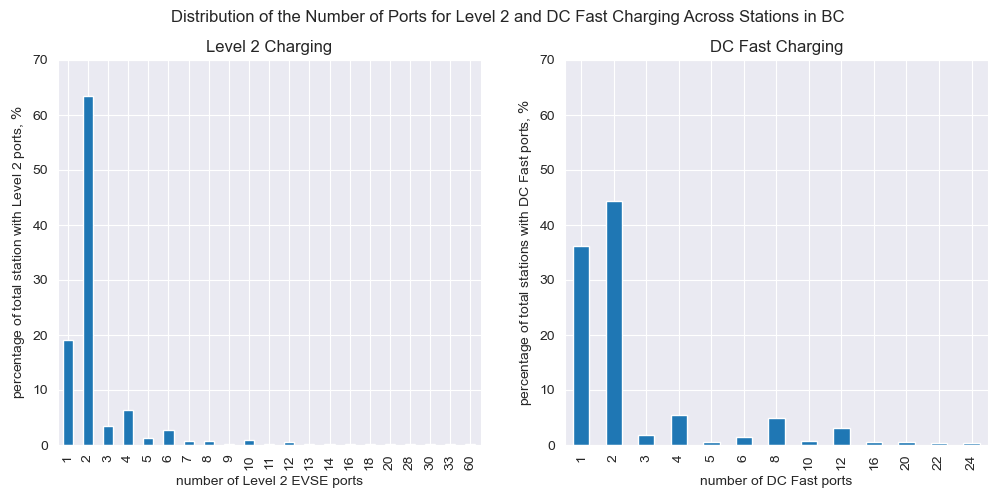

In [143]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
ax1, ax2 = axs

l2_col_name = 'ev_level2_evse_num'
dcfc_col_name = 'ev_dc_fast_num'

(df[[l2_col_name]].copy()
 .dropna()
 .astype('int')
 .groupby(l2_col_name).apply(lambda x: 100.0*(x.count() / df[l2_col_name].notnull().sum()))
).plot.bar(ax=ax1)

(df[[dcfc_col_name]].copy()
 .dropna()
 .astype('int')
 .groupby(dcfc_col_name)
 .apply(lambda x: 100.0*(x.count() / df[dcfc_col_name].notnull().sum()))
).plot.bar(ax=ax2)


ax1.set_ylabel('percentage of total station with Level 2 ports, $\%$')
ax1.set_xlabel('number of Level 2 EVSE ports')

ax2.set_ylabel('percentage of total stations with DC Fast ports, $\%$')
ax2.set_xlabel('number of DC Fast ports')

ax1.set_ylim(0, 70)
ax2.set_ylim(0, 70)

ax1.legend().remove()
ax2.legend().remove()

ax1.set_title('Level 2 Charging')
ax2.set_title('DC Fast Charging')

plt.suptitle('Distribution of the Number of Ports for Level 2 and DC Fast Charging Across Stations in BC');

Highest number of L2 ports for a single station is 60.0, while the highest number of DCFC ports for any station is 24.0.


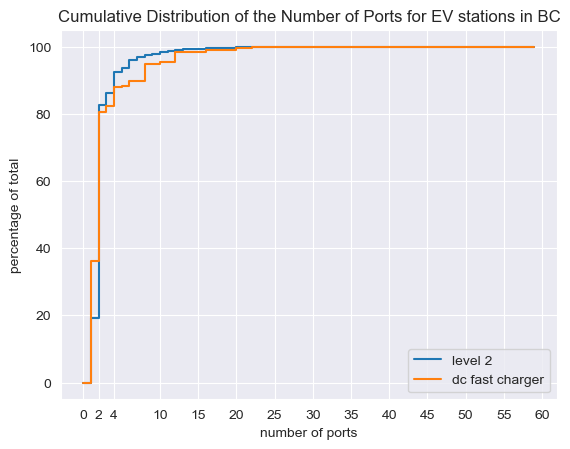

In [94]:
n_l2_charger = df['ev_level2_evse_num'][df['ev_level2_evse_num'].notnull()].values
n_dc_fast = df['ev_dc_fast_num'][df['ev_dc_fast_num'].notnull()].values

print(f"Highest number of L2 ports for a single station is {n_l2_charger.max()}, \
while the highest number of DCFC ports for any station is {n_dc_fast.max()}.")

ecdf_l2 = sm.distributions.ECDF(n_l2_charger, side='left')
ecdf_dcfc = sm.distributions.ECDF(n_dc_fast, side='left')

max_val = np.max(np.concatenate((n_dc_fast, n_l2_charger), axis=0))
min_val = np.min(np.concatenate((n_dc_fast, n_l2_charger), axis=0))

min_val=0.0
x = np.arange(min_val, max_val, )
y_l2 = ecdf_l2(x) * 100
y_dcfc = ecdf_dcfc(x) * 100

fig, ax = plt.subplots()

ls = '-'
ax.step(x, y_l2, ls, label='level 2')
ax.step(x, y_dcfc, ls, label='dc fast charger')


ax.legend()
ax.set_xlabel('number of ports')
ax.set_ylabel('percentage of total')

# left, bottom, width, height = [0.4, 0.4, 0.2, 0.2]
# ax2 = fig.add_axes([left, bottom, width, height])

# ax2.step(x, y_l2, label='level 2')
# ax2.step(x, y_dcfc, label='dc fast charger')
# ax.set_xlim(0, 10)

xticks = [0,2,4] + list(np.arange(10, 61, 5))
ax.set_xticks(xticks);

ax.set_title('Cumulative Distribution of the Number of Ports for EV stations in BC');

The figure represents the cumulative distribution of the number of level 2 and DCFC ports availbale at the various stations.

Although some stations have a high number of ports, about $80\%$ of the stations with both charger types (L2 and DFCC) have no more than 2 ports.

## EV Connector Type <a class="anchor" id="conn-types"></a>

Another point of interest for EV charing is the connector types. While there have been some effort to standardize EV infrasture, the nascent nature of the transition means that various standards still exist. 


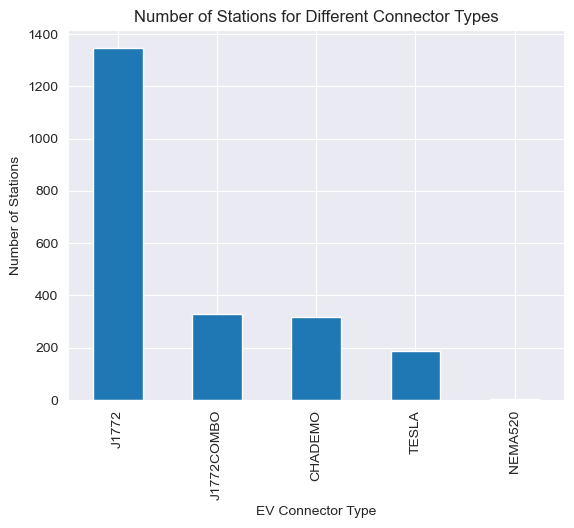

ev_connector_types  ev_level1_evse_num  ev_level2_evse_num  \
23             ['J1772', 'NEMA520']                 1.0                 1.0   
77  ['CHADEMO', 'J1772', 'NEMA520']                 2.0                 6.0   

    ev_dc_fast_num     city  
23             NaN  Kelowna  
77             2.0  Burnaby

In [25]:
from ast import literal_eval

col_name = 'ev_connector_types'

(df[col_name].copy()
 .rename('Connector Types')
 .dropna()
 .apply(literal_eval)
 .explode()
 .value_counts()
).plot.bar();

ax = plt.gca()
ax.set_xlabel('EV Connector Type')
ax.set_ylabel('Number of Stations');
ax.set_title('Number of Stations for Different Connector Types')

plt.show()

# check NEMA520 locations
idxs = []
for i, item in enumerate(df[col_name].values):
    if 'NEMA520' in str(item):
        idxs.append(i)
(df.loc[idxs, ['ev_connector_types','ev_level1_evse_num' ,'ev_level2_evse_num', 'ev_dc_fast_num', 'city']])

The different connector types include the J1772, J1772COMBO, CHADEMO, TESLA, and NEMA520. 

The SAE J1772 is known to be msot popular in North America for level 2 (and level 1) chargers and it is shown to be available in much higher numbers than other connector type. TESLA connector types work for level 1, 2 and DCFC.

There are just 2 NEMA520 connector types. These connectors types are for level 1 charging available at Kelowna and Burnaby.

The other connector types — J1772COMBO, CHADEMO (including  TESLA) are available for DCFC charging. J1772COMBO is expected to increase in popularity given it wide acceptance among automakers.

## EV Pricing <a class="anchor" id="ev-pricing"></a>

In [22]:
print(df[['ev_pricing']]
      .notna()
      .value_counts()
      .reset_index()
      .set_axis(['has price info?','count'], axis=1), '\n')
print(df['ev_pricing'].unique())


   has price info?  count
0            False   1383
1             True    395 

['Free' 'Free; donations accepted' nan '$0.35 per kWh'
 '$3 per hour first 4 hours, $6 per hour for any additional hours'
 'Charging free, parking fee required' 'Free; parking fee required'
 '$5 per session' 'Free for guests'
 '$3.50 per hour for first hour, $4 per hour after' 'Free; parking fee'
 'Variable Fee' 'DC fast: $0.35 per kWh; $2 minimum'
 'Variable parking fee'
 '$0.44 per minute above 60 kW and $0.22 per minute at or below 60 kW'
 '$3 per hour' '$0.21 per minute' 'DCFC: $0.21 per minute'
 '$0.22 per minute' 'Free; $2.0 per hour parking fee' '$2 per hour'
 '$2.00/Hr Parking Fee' 'FREE' '$0.27 per minute' '$0.21 per hour'
 '$0.2113 (CAD) per minute plus tax' '$0.30 per minute'
 'L2: Free; DC Fast: $0.27 per minute' 'DCFC: $0.21 per minute; L2: Free'
 '$0.00-$1.00/Hr Variable Parking Fee' '$1.00 per hour' '$1 per hour'
 '$1.50-$5.50/Hr Variable Parking Fee' '$1.50 per hour'
 'Free for first two hou

The results above show that most of the station have no pricing information in the dataset.

For the few data points with pricing information, there are a variety of pricing rates available. Some stations offer  some form of free charing service ranging  completely free charing or only requiring parking payment, etc. 

Stations with some form of free charging are 

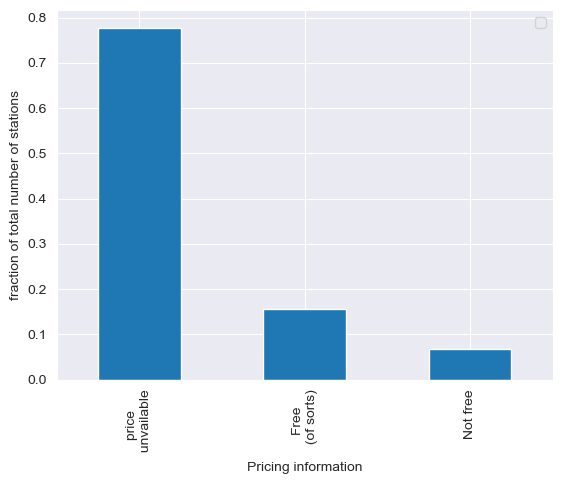

In [23]:
(df['ev_pricing'].copy()
 .str.contains('free', case=False)
 .value_counts(normalize=True, dropna=False)
 .reset_index()
 .replace({True:'Free \n (of sorts)',
         False: 'Not free',
          np.NaN: 'price \n unvailable'})
 .set_index('index')
).plot.bar();

ax = plt.gca()
ax.set_xlabel('Pricing information')
ax.set_ylabel('fraction of total number of stations');
ax.legend('');

## Map of EV locations <a class="anchor" id="ev-map-interactive"></a>

In [95]:
col_names = ['id','longitude', 'latitude', 'ev_level2_evse_num', 
             'ev_dc_fast_num', 'ev_connector_types', 'status_code',
             'ev_pricing','street_address' ]

temp_df = (df[col_names].copy()
           .fillna({'ev_level2_evse_num':0,
                   'ev_dc_fast_num':0})
           .assign(free_charging=lambda x: x['ev_pricing']
                   .str.contains('free', case=False))
          )

max_l2_ports = temp_df['ev_level2_evse_num'].max()
max_dcfc_ports = temp_df['ev_dc_fast_num'].max()


def plot_map(status='all', min_l2_ports=0, min_dcfc_ports=0, free_charging=False):
    if status=='all':
        select_df = temp_df.copy()
    else:
        select_df = temp_df[temp_df['status_code'] ==status].copy()
    

    condition = (select_df['ev_level2_evse_num']>=min_l2_ports) & (select_df['ev_dc_fast_num']>=min_dcfc_ports)
    
    select_df = select_df[condition].copy()
    
    if free_charging:
        select_df = select_df[select_df['free_charging']==free_charging].copy()

    def _plot(select_df):
        
        m = folium.Map(location=[49.2827, -123.1207], tiles="OpenStreetMap", zoom_start=9)
        
        for i, id in enumerate(select_df.id):

            row = select_df[select_df['id']==id]

            status_code = row['status_code'].iloc[0]
            n_l2_ports = row['ev_level2_evse_num'].iloc[0]
            n_dcfc_ports = row['ev_dc_fast_num'].iloc[0]
            address = row['street_address'].iloc[0]

            popup = folium.Popup(f"# of L2 ports:{n_l2_ports} <br> \
                                # of DCFC ports:{n_dcfc_ports} <br> \
                                 status: {status_code} <br> \
                                 address: {address}", 
                                min_width=300, max_width=300)
            folium.CircleMarker([row.latitude, row.longitude],
                                popup=popup,
                                #icon=folium.Icon(color='green', icon='charging-station', prefix='fa')
                                radius=3
                               ).add_to(m)

        return m
    
    m = _plot(select_df)
    # m.save("../reports/map.html")
    display(m)
    return m



In [96]:
import ipywidgets as wgt
from ipywidgets import interactive

# layout = wgt.Layout(width='auto', height='40px') #set width and height
style = {'description_width': 'initial'}
all_option = ['all']
status_list = all_option + list(df['status_code'].unique())

status_val = wgt.Dropdown(options=status_list, description='status:')
# free_charging = wgt.Dropdown(options=free_charing_status_list)
free_charging = wgt.Checkbox(value=False, description='Free charging available')
l2_port_min = wgt.IntSlider(value=0, min=0, step=1, max=max_l2_ports, description='Min. # of L2 ports:', style=style )
dcfc_port_min = wgt.IntSlider(value=0, min=0, step=1, max=max_dcfc_ports, description='Min. # of DCFC ports:', style=style)


interactive(plot_map, 
            status=status_val, 
            min_l2_ports=l2_port_min,
            min_dcfc_ports=dcfc_port_min,
            free_charging=free_charging)


interactive(children=(Dropdown(description='status:', options=('all', 'E', 'P'), value='all'), IntSlider(value…

The above is an interctive map of station location in BC.

The following Control widgets are included to provide relevant filtering of the stations:

- `status`: this enables the filtering of the station locations to either include only available stations (E), planned stations (P), or all stations
- `Min. # of L2 ports`: filters by showing only those station locations where the number of level 2 charging ports are greater than the set minimum 
- `Min. # of DCFC ports`: filters by showing only those station locations where the number of DC fast charging ports are greater than the set minimum.
- `Free charging available`: when checked, only stations with some form of available free charging are displayed on the map. Otherwise, all stations are shown.

### Some Map Excerpts <a class="anchor" id="map-excerpts"></a>

In [101]:
stn_max_l2_port = {}
snap_shots_params = {
    'all stations':{'status':'all'},
    'station with maximum number of ports':{ 'min_l2_ports':60},
    'planned stations only': {'status':'E'},
    'staions with free charging':{'free_charging':True},
    'stations with fast charging capability':{'min_dcfc_ports':1}
}

for k, v in snap_shots_params.items():

    
    m = plot_map(**v)
    save_path = os.path.normpath(f"../reports/{k}.html")
    m.save(save_path)

# Utility Functions

In [152]:
def get_raw_data(file_path, update=False):
    
    '''retrieve exisiting raw data either from `file_path` or from api if update=True'''
    
    if not update:
        try:
            data = pd.read_csv(file_path)
        except FileNotFoundError:
            print("file does not exist, downloading data instead")
            data = _pull_data()
    else:
        data = _pull_data()
        
    data.to_csv(file_path)
        
    return data
        
    
    
def _pull_data():
    api_key = os.environ['API_KEY']
    query_params = {'api_key':api_key, 
                'country':'CA',
                'state':'BC',
               'access':'public',
               'status':'E,P',
               'owner_type': 'all',
               'cards_accepted': 'all',
               'fuel_type':'ELEC',
               'ev_charging_level':'2,dc_fast',
               'ev_connector_type': 'all',
               'ev_network':'all'}
    response = requests.get("http://developer.nrel.gov/api/alt-fuel-stations/v1.json", params=query_params)
    r_dict = response.json()
    raw_data = pd.json_normalize(r_dict['fuel_stations'])
    
    return raw_data

# Sources <a class="anchor" id="sources"></a>

1. https://www.chargepoint.com/files/Quick_Guide_to_Fast_Charging.pdf
2. https://www.evgo.com/ev-drivers/charging-basics/
3. https://electricvehicles.bchydro.com/charge/choosing-a-home-EV-charger